# Figure 2: overview of TFIso1.0 clone collection/dataset

In [245]:
import matplotlib as mpl
import met_brewer
import pandas as pd
import numpy as np
import seaborn as sns
import sys

from matplotlib import pyplot as plt
from scipy import stats

# import utils
sys.path.append("../")

from data_loading import (load_valid_isoform_clones,
                          load_y2h_isoform_data,
                          load_y1h_pdi_data,
                          load_m1h_activation_data,
                          load_annotated_gencode_tfs,
                          load_annotated_TFiso1_collection,
                          load_developmental_tissue_expression_remapped,
                          load_gtex_remapped,
                          load_tf_families)

from plotting import PAPER_PRESET, PAPER_FONTSIZE, nice_boxplot, nice_violinplot, mimic_r_boxplot


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2023)

In [22]:
rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

## 1. load clone collection and gencode

In [4]:
genc_tfs = load_annotated_gencode_tfs()

reading from cache


In [5]:
clone_tfs = load_annotated_TFiso1_collection()

100%|██████████| 1009/1009 [00:31<00:00, 31.76it/s]


reading from cache
missing disorder data for ZBTB18-1
missing disorder data for ZBTB18-2
missing disorder data for ZBTB48-1
missing disorder data for PRDM16-1
missing disorder data for PRDM16-2
missing disorder data for ZBTB49-1
missing disorder data for ZNF655-1
missing disorder data for ZNF655-2
missing disorder data for ZNF212-1
missing disorder data for ZNF212-2
missing disorder data for ZBTB16-1
missing disorder data for ZBTB16-2
missing disorder data for ZBTB44-1
missing disorder data for GLI1-1
missing disorder data for GLI1-2
missing disorder data for GLI1-3
missing disorder data for ZBTB1-1
missing disorder data for ZNF263-1
missing disorder data for E4F1-1
missing disorder data for ZSCAN32-1
missing disorder data for SP2-1
missing disorder data for ZNF18-1
missing disorder data for ZNF473-1
missing disorder data for ZNF341-1
missing disorder data for ZNF341-2
missing disorder data for ZFY-1
missing disorder data for ZFY-2


## 2. splicing category figures

### first: GENCODE

In [6]:
alt_n = 0
alt_c = 0
alt_int = 0
alt_5ss = 0
alt_3ss = 0
exon_sk = 0
mut_ex = 0
intron_ret = 0
tot = 0

for tf in genc_tfs.keys():
    gene = genc_tfs[tf]
    ref = gene.reference_isoform.name
    alts = [x.name for x in gene.alternative_isoforms]
    for alt in alts:
        splicing_cats = gene.splicing_categories(ref, alt)
        
        if splicing_cats['alternative N-terminal']:
            alt_n += 1
        if splicing_cats['alternative C-terminal']:
            alt_c += 1
        if splicing_cats['alternative internal exon']:
            alt_int += 1
        if splicing_cats['alternative 5\' splice site']:
            alt_5ss += 1
        if splicing_cats['alternative 3\' splice site']:
            alt_3ss += 1
        if splicing_cats['exon skipping']:
            exon_sk += 1
        if splicing_cats['mutually exclusive exons']:
            mut_ex += 1
        if splicing_cats['intron retention']:
            intron_ret += 1
        
        tot += 1

genc_df = pd.DataFrame.from_dict({"alt. N-terminal": [alt_n], "alt. C-terminal": [alt_c],
                                  "alt. internal exon": [alt_int], "alt. 5' splice site": [alt_5ss],
                                  "alt. 3' splice site": [alt_3ss], "exon skipping": [exon_sk],
                                  "mutually exclusive exons": [mut_ex], "intron retention": [intron_ret],
                                  "total": tot})
genc_df.index = ["gencode"]
genc_df

,alt. N-terminal,alt. C-terminal,alt. internal exon,alt. 5' splice site,alt. 3' splice site,exon skipping,mutually exclusive exons,intron retention,total
gencode,1046,1071,430,686,879,330,26,72,1855


### next: TFIso1.0

In [7]:
alt_n = 0
alt_c = 0
alt_int = 0
alt_5ss = 0
alt_3ss = 0
exon_sk = 0
mut_ex = 0
intron_ret = 0
tot = 0

for tf in clone_tfs.keys():
    gene = clone_tfs[tf]
    ref = gene.cloned_reference_isoform.name
    alts = [x.name for x in gene.cloned_isoforms if x.name != ref]
    for alt in alts:
        splicing_cats = gene.splicing_categories(ref, alt)
        
        if splicing_cats['alternative N-terminal']:
            alt_n += 1
        if splicing_cats['alternative C-terminal']:
            alt_c += 1
        if splicing_cats['alternative internal exon']:
            alt_int += 1
        if splicing_cats['alternative 5\' splice site']:
            alt_5ss += 1
        if splicing_cats['alternative 3\' splice site']:
            alt_3ss += 1
        if splicing_cats['exon skipping']:
            exon_sk += 1
        if splicing_cats['mutually exclusive exons']:
            mut_ex += 1
        if splicing_cats['intron retention']:
            intron_ret += 1
        
        tot += 1

clone_df = pd.DataFrame.from_dict({"alt. N-terminal": [alt_n], "alt. C-terminal": [alt_c],
                                  "alt. internal exon": [alt_int], "alt. 5' splice site": [alt_5ss],
                                  "alt. 3' splice site": [alt_3ss], "exon skipping": [exon_sk],
                                  "mutually exclusive exons": [mut_ex], "intron retention": [intron_ret],
                                  "total": tot})
clone_df.index = ["TFIso1.0"]
clone_df

,alt. N-terminal,alt. C-terminal,alt. internal exon,alt. 5' splice site,alt. 3' splice site,exon skipping,mutually exclusive exons,intron retention,total
TFIso1.0,169,198,136,179,218,116,5,14,447


### then: novel isoforms

In [8]:
alt_n = 0
alt_c = 0
alt_int = 0
alt_5ss = 0
alt_3ss = 0
exon_sk = 0
mut_ex = 0
intron_ret = 0
tot = 0

for tf in clone_tfs.keys():
    gene = clone_tfs[tf]
    ref = gene.cloned_reference_isoform.name
    novels = [x.name for x in gene.cloned_isoforms if x.is_novel_isoform()]
    for novel in novels:
        splicing_cats = gene.splicing_categories(ref, novel)
        
        if splicing_cats['alternative N-terminal']:
            alt_n += 1
        if splicing_cats['alternative C-terminal']:
            alt_c += 1
        if splicing_cats['alternative internal exon']:
            alt_int += 1
        if splicing_cats['alternative 5\' splice site']:
            alt_5ss += 1
        if splicing_cats['alternative 3\' splice site']:
            alt_3ss += 1
        if splicing_cats['exon skipping']:
            exon_sk += 1
        if splicing_cats['mutually exclusive exons']:
            mut_ex += 1
        if splicing_cats['intron retention']:
            intron_ret += 1
        
        tot += 1

novel_df = pd.DataFrame.from_dict({"alt. N-terminal": [alt_n], "alt. C-terminal": [alt_c],
                                  "alt. internal exon": [alt_int], "alt. 5' splice site": [alt_5ss],
                                  "alt. 3' splice site": [alt_3ss], "exon skipping": [exon_sk],
                                  "mutually exclusive exons": [mut_ex], "intron retention": [intron_ret],
                                  "total": tot})
novel_df.index = ["TFIso1.0 - novel"]
novel_df

,alt. N-terminal,alt. C-terminal,alt. internal exon,alt. 5' splice site,alt. 3' splice site,exon skipping,mutually exclusive exons,intron retention,total
TFIso1.0 - novel,47,70,81,71,103,69,4,7,191


### make plot

In [9]:
splicing = genc_df.append(clone_df).append(novel_df)
splicing_tot = splicing["total"]
splicing = splicing.drop("total", axis=1)
splicing_perc = splicing.divide(splicing_tot, axis='rows').reset_index()
splicing_perc

,index,alt. N-terminal,alt. C-terminal,alt. internal exon,alt. 5' splice site,alt. 3' splice site,exon skipping,mutually exclusive exons,intron retention
0,gencode,0.563881,0.577358,0.231806,0.369811,0.473854,0.177898,0.014016,0.038814
1,TFIso1.0,0.378076,0.442953,0.304251,0.400447,0.487696,0.259508,0.011186,0.031320
2,TFIso1.0 - novel,0.246073,0.366492,0.424084,0.371728,0.539267,0.361257,0.020942,0.036649


In [10]:
splicing_perc_melt = pd.melt(splicing_perc, id_vars="index")

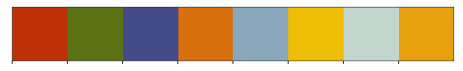

In [11]:
colors = met_brewer.met_brew(name="VanGogh2")
sns.palplot(colors)

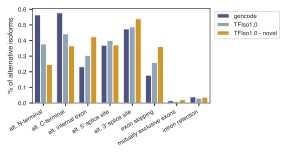

In [15]:
fig = plt.figure(figsize=(3.2, 1.75))

ax = sns.barplot(data=splicing_perc_melt, x="variable", y="value", hue="index", palette={"gencode": colors[2],
                                                                                         "TFIso1.0": colors[4],
                                                                                         "TFIso1.0 - novel": colors[7]})
ax.set_xlabel("")
ax.set_xticklabels(list(splicing_perc_melt["variable"].unique()), ha="right", va="top", rotation=30)
ax.set_ylabel("% of alternative isoforms")

plt.legend(loc=2, bbox_to_anchor=(1.01, 1))

fig.savefig("../../figures/fig2/splicing_cats.pdf", dpi="figure", bbox_inches="tight")

## 3. plot expression of novel isoforms

In [18]:
status_map = {}

# only loop through clone collection
for tf in clone_tfs.keys():
    gene = clone_tfs[tf]
    
    try:
        annot_ref = gene.reference_isoform.name
    except:
        annot_ref = "none"
        
    try:
        annot_alt = gene.alternative_isoforms
    except:
        annot_alt = []
        
    for iso in gene.cloned_isoforms:
        if iso.name == annot_ref:
            status_map[iso.clone_acc] = {"gene_name": tf, "status": "ref"}
        elif iso.is_novel_isoform():
            status_map[iso.clone_acc] = {"gene_name": tf, "status": "novel"}
        else:
            status_map[iso.clone_acc] = {"gene_name": tf, "status": "alt"}

In [19]:
status_map = pd.DataFrame.from_dict(status_map, orient="index")
status_map

,gene_name,status
ZBTB18|1/2|04E08,ZBTB18,ref
ZBTB18|2/2|12E05,ZBTB18,alt
PRRX1|1/3|09C07,PRRX1,alt
PRRX1|2/3|09F06,PRRX1,ref
PRRX1|3/3|09H08,PRRX1,alt
...,...,...
HDX|2/2|09H10,HDX,novel
ZFY|1/2|06H10,ZFY,novel
ZFY|2/2|06E10,ZFY,novel
HSFY1|1/2|12F03,HSFY1,novel


In [23]:
df_dev, metadata_dev, genes_dev = load_developmental_tissue_expression_remapped()

rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

metadata_dev['dev_stage'] = metadata_dev['Developmental_Stage'].map(rename_dev_stage)
means_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())

reading from cache


In [25]:
df_gtex, metadata_gtex, genes_gtex = load_gtex_remapped()

exclusion_list_gtex = {'Cells - Leukemia cell line (CML)',
                       'Cells - EBV-transformed lymphocytes',
                       'Cells - Cultured fibroblasts'}

df_gtex = df_gtex.loc[:, ~df_gtex.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex = metadata_gtex.loc[~metadata_gtex['body_site'].isin(exclusion_list_gtex), :]

means_gtex = df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean()

reading from cache


In [27]:
metadata_gtex_dummy = pd.read_table("../../data/processed/metadata_gtex_dummy.csv", sep=",", index_col=0)

In [28]:
# use same downsample as fig1
means_gtex_downsample = df_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean()

In [29]:
means_dev["median"] = means_dev.median(axis=1)
means_dev["max"] = means_dev.max(axis=1)

means_gtex_downsample["median"] = means_gtex_downsample.median(axis=1)
means_gtex_downsample["max"] = means_gtex_downsample.max(axis=1)

In [30]:
dev_mm = means_dev[["median", "max"]].reset_index()
gtex_ds_mm = means_gtex_downsample[["median", "max"]].reset_index()

In [31]:
dev_mm["clone_acc"] = dev_mm["UID"].str.split(" ", expand=True)[0]
gtex_ds_mm["clone_acc"] = gtex_ds_mm["UID"].str.split(" ", expand=True)[0]
mm = dev_mm[dev_mm["clone_acc"] != "noclone"].merge(gtex_ds_mm[gtex_ds_mm["clone_acc"] != "noclone"], 
                                                    on="clone_acc", suffixes=("_dev", "_gtex_ds"))

In [32]:
status_map = status_map.reset_index()
status_map["clone_acc"] = status_map["index"].str.split(" ", expand=True)[0]

In [33]:
exp_nov = status_map.merge(mm, on="clone_acc")
exp_nov_melt = pd.melt(exp_nov, id_vars=["index", "gene_name", "status", "clone_acc"], value_vars=["median_dev",
                                                                                                   "max_dev",
                                                                                                   "median_gtex_ds",
                                                                                                   "max_gtex_ds"])
exp_nov_melt["measurement"] = exp_nov_melt["variable"].str.split("_", expand=True)[0]

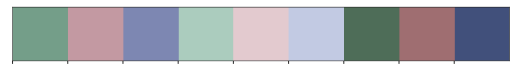

In [34]:
colors = met_brewer.met_brew(name="Monet")
sns.palplot(colors)

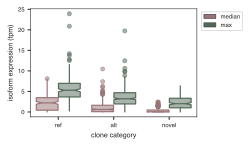

In [36]:
fig = plt.figure(figsize=(3, 2))

exp_nov_melt["value_log2"] = np.log2(exp_nov_melt["value"]+1)
ax = sns.boxplot(data=exp_nov_melt[exp_nov_melt["variable"].str.contains("dev")], 
                 x="status", y="value", hue="measurement", palette={"median": colors[7],
                                                                    "max": colors[6]}, 
                 flierprops={"marker": "o"}, fliersize=4, notch=True)

mimic_r_boxplot(ax)

plt.legend(loc=2, bbox_to_anchor=(1.01, 1))

ax.set_xlabel("clone category")
ax.set_ylabel("isoform expression (tpm)")

fig.savefig("../../figures/fig2/novel_isos.dev_expr_boxplot.pdf", dpi="figure", bbox_inches="tight")

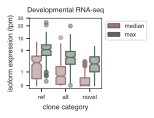

In [278]:
fig = plt.figure(figsize=(1.3, 1.3))

ax = sns.boxplot(data=exp_nov_melt[exp_nov_melt["variable"].str.contains("dev")], 
                 x="status", y="value_log2", hue="measurement", palette={"median": colors[7],
                                                                    "max": colors[6]}, 
                 flierprops={"marker": "o"}, fliersize=4, notch=True)

mimic_r_boxplot(ax)

plt.legend(loc=2, bbox_to_anchor=(1.01, 1))

ax.set_xlabel("clone category")
ax.set_ylabel("isoform expression (tpm)")

ticks = [0, 1, 5, 10, 20, 30]
ticklabels = [0, 1, 5, 10, 20, 30]
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)
ax.tick_params(axis='y', labelsize=fontsize-2)
plt.title("Developmental RNA-seq")

fig.savefig("../../figures/fig2/novel_isos.dev_expr_boxplot.log2.pdf", dpi="figure", bbox_inches="tight")

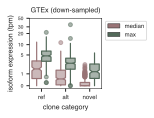

In [279]:
fig = plt.figure(figsize=(1.3, 1.3))

ax = sns.boxplot(data=exp_nov_melt[exp_nov_melt["variable"].str.contains("gtex_ds")], 
                 x="status", y="value_log2", hue="measurement", palette={"median": colors[7],
                                                                    "max": colors[6]}, 
                 flierprops={"marker": "o"}, fliersize=4, notch=True)

mimic_r_boxplot(ax)

plt.legend(loc=2, bbox_to_anchor=(1.01, 1))

ax.set_xlabel("clone category")
ax.set_ylabel("isoform expression (tpm)")

ticks = [0, 1, 5, 10, 20, 30, 50]
ticklabels = [0, 1, 5, 10, 20, 30, 50]
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)
ax.tick_params(axis='y', labelsize=fontsize-2)
plt.title("GTEx (down-sampled)")

fig.savefig("../../figures/fig2/novel_isos.gtex_ds_expr_boxplot.log2.pdf", dpi="figure", bbox_inches="tight")

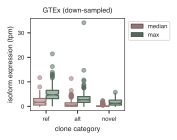

In [59]:
fig = plt.figure(figsize=(1.7, 1.7))

ax = sns.boxplot(data=exp_nov_melt[exp_nov_melt["variable"].str.contains("gtex_ds")], 
                 x="status", y="value", hue="measurement", palette={"median": colors[7],
                                                                    "max": colors[6]}, 
                 flierprops={"marker": "o"}, fliersize=4, notch=True)

mimic_r_boxplot(ax)

plt.legend(loc=2, bbox_to_anchor=(1.01, 1))

ax.set_xlabel("clone category")
ax.set_ylabel("isoform expression (tpm)")


plt.title("GTEx (down-sampled)")

fig.savefig("../../figures/fig2/novel_isos.gtex_ds_expr_boxplot.pdf", dpi="figure", bbox_inches="tight")

## 4. plot representation of families across assays

In [176]:
fam = load_tf_families()

### gencode

In [177]:
len(genc_tfs)

1635

In [178]:
genc_df = {k: genc_tfs[k].GENCODE_isoforms for k in genc_tfs.keys()}
genc_df = {k: [v.name for v in values] for k, values in genc_df.items()}
genc_df = [(k, v) for k, sublist in genc_df.items() for v in sublist]
genc_df = pd.DataFrame(genc_df, columns=["gene", "isoform"])
genc_df['family'] = genc_df['gene'].map(fam)
genc_df.sample(5)

,gene,isoform,family
814,ZNF732,ZNF732-201,C2H2 ZF
617,MITF,MITF-203,bHLH
289,SMYD3,SMYD3-204,Unknown
2405,TCF12,TCF12-206,bHLH
3618,ZNF573,ZNF573-204,C2H2 ZF


In [179]:
leave_separate = ["C2H2 ZF", "Homeodomain", "bHLH", "Nuclear receptor", "bZIP", "Forkhead", "Ets"]

def rename_family(row):
    if row.family in leave_separate:
        return row.family
    else:
        return "Other"
    
genc_df['family_renamed'] = genc_df.apply(rename_family, axis=1)
genc_df.sample(5)

,gene,isoform,family,family_renamed
3425,ZNF324,ZNF324-201,C2H2 ZF,C2H2 ZF
1541,TRPS1,TRPS1-201,GATA,Other
510,ATF2,ATF2-221,bZIP,bZIP
1929,ZNF195,ZNF195-201,C2H2 ZF,C2H2 ZF
3844,EBF4,EBF4-202,EBF1,Other


In [180]:
genc_vc = genc_df.groupby("family_renamed")["isoform"].agg("count").reset_index()
genc_vc["source"] = "GENCODE"
genc_vc

,family_renamed,isoform,source
0,C2H2 ZF,1840,GENCODE
1,Ets,89,GENCODE
2,Forkhead,97,GENCODE
3,Homeodomain,350,GENCODE
4,Nuclear receptor,176,GENCODE
5,Other,1179,GENCODE
6,bHLH,264,GENCODE
7,bZIP,149,GENCODE


### TF Iso 1.0

In [181]:
len(clone_tfs)

309

In [219]:
clone_df = {k: clone_tfs[k].cloned_isoforms for k in clone_tfs.keys()}
clone_df = {k: [v.clone_acc for v in values] for k, values in clone_df.items()}
clone_df = [(k, v) for k, sublist in clone_df.items() for v in sublist]
clone_df = pd.DataFrame(clone_df, columns=["gene", "isoform"])
clone_df['family'] = clone_df['gene'].map(fam)
clone_df.sample(5)

,gene,isoform,family
348,LCOR,LCOR|2/2|12B05,Pipsqueak
623,ZNF544,ZNF544|2/7|02H06,C2H2 ZF
220,TFAP2A,TFAP2A|2/4|09G07,AP-2
301,EBF2,EBF2|2/2|04B11,EBF1
398,SOX6,SOX6|6/7|07F08,HMG/Sox


In [220]:
len(clone_df)

756

In [221]:
len(clone_df.gene.unique())

309

In [183]:
def rename_family(row):
    if row.family in leave_separate:
        return row.family
    else:
        return "Other"
    
clone_df['family_renamed'] = clone_df.apply(rename_family, axis=1)

In [184]:
clone_vc = clone_df.groupby("family_renamed")["isoform"].agg("count").reset_index()
clone_vc["source"] = "TFIso1.0"

### Y1H

In [185]:
y1h = load_y1h_pdi_data()
y1h['family'] = y1h['tf'].map(fam)
y1h['family_renamed'] = y1h.apply(rename_family, axis=1)
y1h.sample(5)

,tf,unique_acc,HS1006,HS1022,HS1043,HS1067,HS1139,HS1142,HS118,HS1181,...,PF4V1,TNFSF10,TNFSF13,TNFSF14,TNFSF4,TNFSF8,XCL1,XCL2,family,family_renamed
47,HMGA1,HMGA1|1/2|11C02,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,AT hook,Other
122,RFX4,RFX4|3/3|12B07,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,RFX,Other
142,TFAP2A,TFAP2A|1/4|09D09,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,AP-2,Other
116,PRRX1,PRRX1|3/3|09H08,False,False,False,True,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Homeodomain,Homeodomain
106,POU2F2,POU2F2|4/4|11A08,False,False,False,False,False,False,False,True,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Homeodomain; POU,Other


In [207]:
len(y1h)

191

In [208]:
len(y1h.tf.unique())

97

In [186]:
baits = [x for x in y1h.columns if x not in ['tf', 'unique_acc', 'family', 'family_renamed']]
y1h['any_true'] = y1h[baits].sum(axis=1)
y1h

,tf,unique_acc,HS1006,HS1022,HS1043,HS1067,HS1139,HS1142,HS118,HS1181,...,TNFSF10,TNFSF13,TNFSF14,TNFSF4,TNFSF8,XCL1,XCL2,family,family_renamed,any_true
0,CREB1,CREB1|1/2|02E01,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,bZIP,bZIP,0.0
1,CREB1,CREB1|2/2|01F12,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,bZIP,bZIP,4.0
2,DLX1,DLX1|1/2|07A12,False,False,False,<NA>,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Homeodomain,Homeodomain,3.0
3,DLX1,DLX1|2/2|07E09,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Homeodomain,Homeodomain,0.0
4,DLX4,DLX4|1/3|11A04,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Homeodomain,Homeodomain,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,ZNF18,ZNF18|3/3|07D01,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,C2H2 ZF,C2H2 ZF,1.0
169,ZNF320,ZNF320|1/2|12A05,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,C2H2 ZF,C2H2 ZF,0.0
170,ZNF438,ZNF438|1/2|09H05,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,C2H2 ZF,C2H2 ZF,0.0
171,ZNF438,ZNF438|2/2|09E04,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,C2H2 ZF,C2H2 ZF,3.0


In [187]:
y1h_vc = y1h.groupby("family_renamed")["unique_acc"].agg("count").reset_index()
y1h_vc.columns = ["family_renamed", "isoform"]
y1h_vc["source"] = "Y1H (all)"

In [188]:
y1h_any_vc = y1h[y1h['any_true'] > 0].groupby("family_renamed")["unique_acc"].agg("count").reset_index()
y1h_any_vc.columns = ["family_renamed", "isoform"]
y1h_any_vc["source"] = "Y1H (≥1 PDI)"

### Y2H

In [189]:
y2h = load_y2h_isoform_data()
y2h['family'] = y2h['ad_gene_symbol'].map(fam)
y2h['family_renamed'] = y2h.apply(rename_family, axis=1)
y2h.sample(5)

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result,family,family_renamed
7243,TCF4|6/9|07H03,TCF4,BANF2,False,bHLH,bHLH
6071,TCF4|5/9|07C02,TCF4,SSX1,True,bHLH,bHLH
8903,MEOX1|2/3|08G04,MEOX1,EIF4EBP1,False,Homeodomain,Homeodomain
394,TP63|1/3|07F10,TP63,ZBTB25,True,p53,Other
7663,ZNF438|2/2|09E04,ZNF438,ZBTB16,True,C2H2 ZF,C2H2 ZF


In [209]:
len(y2h.ad_clone_acc.unique())

166

In [210]:
len(y2h.ad_gene_symbol.unique())

63

In [190]:
y2h_vc = y2h.groupby("family_renamed")["ad_clone_acc"].agg("count").reset_index()
y2h_vc.columns = ["family_renamed", "isoform"]
y2h_vc["source"] = "Y2H (all)"

In [191]:
y2h_any_vc = y2h[y2h["Y2H_result"] == True].groupby("family_renamed")["ad_clone_acc"].agg("count").reset_index()
y2h_any_vc.columns = ["family_renamed", "isoform"]
y2h_any_vc["source"] = "Y2H (≥1 PPI)"

### activation

In [192]:
m1h = load_m1h_activation_data()
m1h['M1H_mean'] = m1h[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1)
m1h['family'] = m1h['gene'].map(fam)
m1h['family_renamed'] = m1h.apply(rename_family, axis=1)
m1h.sample(5)

,gene,clone_acc,M1H_rep1,M1H_rep2,M1H_rep3,M1H_mean,family,family_renamed
103,LEF1,LEF1|2/5|07F03,-0.315715,-0.487163,-0.556997,-0.453292,HMG/Sox,Other
496,TFCP2,TFCP2|2/3|03H07,1.313428,1.580257,1.505315,1.466333,Grainyhead,Other
23,DLX1,DLX1|2/2|07E09,3.979549,3.860412,3.928972,3.922978,Homeodomain,Homeodomain
605,ZNF655,ZNF655|4/6|03C06,1.666138,1.650795,1.523808,1.613580,C2H2 ZF,C2H2 ZF
583,ZNF451,ZNF451|4/8|06H02,0.051569,-0.135836,-0.159615,-0.081294,C2H2 ZF,C2H2 ZF


In [211]:
len(m1h.clone_acc.unique())

622

In [212]:
len(m1h.gene.unique())

264

In [193]:
m1h_vc = m1h.groupby("family_renamed")["clone_acc"].agg("count").reset_index()
m1h_vc.columns = ["family_renamed", "isoform"]
m1h_vc["source"] = "M1H (all)"

In [198]:
m1h_any_vc = m1h[m1h["M1H_mean"].abs() > 1].groupby("family_renamed")["clone_acc"].agg("count").reset_index()
m1h_any_vc.columns = ["family_renamed", "isoform"]
m1h_any_vc["source"] = "M1H (≥2-fold activ.)"

### merge for plot

In [199]:
mrg_vc = genc_vc.append(clone_vc)
mrg_vc = mrg_vc.append(y1h_vc).append(y1h_any_vc)
mrg_vc = mrg_vc.append(y2h_vc).append(y2h_any_vc)
mrg_vc = mrg_vc.append(m1h_vc).append(m1h_any_vc)
mrg_vc

,family_renamed,isoform,source
0,C2H2 ZF,1840,GENCODE
1,Ets,89,GENCODE
2,Forkhead,97,GENCODE
3,Homeodomain,350,GENCODE
4,Nuclear receptor,176,GENCODE
...,...,...,...
3,Homeodomain,36,M1H (≥2-fold activ.)
4,Nuclear receptor,32,M1H (≥2-fold activ.)
5,Other,98,M1H (≥2-fold activ.)
6,bHLH,32,M1H (≥2-fold activ.)


In [293]:
mrg_piv = pd.pivot_table(mrg_vc, values="isoform", columns="source", index="family_renamed")
mrg_piv = mrg_piv.fillna(0)
mrg_piv = (mrg_piv/mrg_piv.sum(axis=0))*100
mrg_piv = mrg_piv.T
mrg_piv = mrg_piv.reindex(["GENCODE", "TFIso1.0", "Y1H (all)", "Y1H (≥1 PDI)",
                           "Y2H (all)", "Y2H (≥1 PPI)", "M1H (all)", "M1H (≥2-fold activ.)"])
mrg_piv = mrg_piv.reset_index()

mrg_piv = mrg_piv[["source", "Other", "Ets", "Forkhead", "bZIP", "Nuclear receptor",
                   "bHLH", "Homeodomain", "C2H2 ZF"]]
mrg_piv

family_renamed,source,Other,Ets,Forkhead,bZIP,Nuclear receptor,bHLH,Homeodomain,C2H2 ZF
0,GENCODE,28.450772,2.147683,2.340734,3.595560,4.247104,6.370656,8.445946,44.401544
1,TFIso1.0,25.925926,3.968254,2.248677,3.835979,7.142857,7.936508,8.465608,40.476190
2,Y1H (all),37.172775,3.141361,4.188482,1.047120,10.994764,9.424084,17.801047,16.230366
3,Y1H (≥1 PDI),34.108527,2.325581,3.875969,0.775194,15.503876,9.302326,18.604651,15.503876
4,Y2H (all),11.633903,0.000000,2.320335,3.029326,2.707058,46.084434,11.827264,22.397680
5,Y2H (≥1 PPI),13.043478,0.000000,2.296043,3.566194,3.615046,50.610650,10.454323,16.414265
6,M1H (all),25.562701,3.376206,2.733119,4.019293,7.717042,7.395498,9.324759,39.871383
7,M1H (≥2-fold activ.),26.702997,4.632153,3.269755,4.087193,8.719346,8.719346,9.809264,34.059946


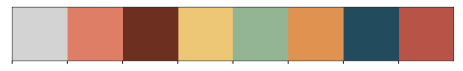

In [294]:
colors = met_brewer.met_brew(name="Hokusai1")
colors.append("lightgrey")
colors = colors[::-1]
#colors[7] = "lightgrey"
sns.palplot(colors)

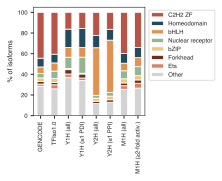

In [302]:
ax = mrg_piv.plot.bar(x="source", stacked=True, color=colors, figsize=(2, 2))

ax.set_ylabel("% of isoforms")
ax.set_xlabel("")

plt.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc=2, bbox_to_anchor=(1.01, 1))

plt.savefig('../../figures/fig2/assay_families.detailed.pdf',
            bbox_inches='tight')

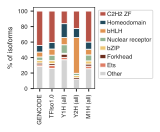

In [311]:
ax = mrg_piv[mrg_piv["source"].isin(["GENCODE", "TFIso1.0", "Y1H (all)",
                  "Y2H (all)", "M1H (all)"])].plot.bar(x="source", stacked=True, color=colors, figsize=(1.1, 1.5))

ax.set_ylabel("% of isoforms")
ax.set_xlabel("")

plt.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc=2, bbox_to_anchor=(1.01, 1), borderpad=0.25,
          handlelength=1, handletextpad=0.2)

plt.savefig('../../figures/fig2/assay_families.pdf',
            bbox_inches='tight')

## 5. plot biochemical activities of TFs across ref/alt/novel

In [230]:
mane_select_clones = {tf.MANE_select_isoform.clone_acc for tf in clone_tfs.values() 
                      if tf.cloned_MANE_select_isoform}

In [232]:
iso = load_valid_isoform_clones()
iso['is_longest_isoform'] = iso['clone_acc'].isin(iso.sort_values('num_aa', 
                                                                  ascending=False).groupby('gene').nth(0)['clone_acc'].values)
iso['category'] = 'alternative'
iso.loc[iso['clone_acc'].isin(mane_select_clones), 'category'] = 'reference'
iso.loc[iso['is_novel_isoform'], 'category'] = 'novel'

In [236]:
len(iso['gene'].unique())

310

In [235]:
genes_w_ref = list(iso[iso['category'] == 'reference']['gene'].unique())
len(genes_w_ref)

195

In [237]:
# subset iso df to only genes w MANE select isoform
iso_sub = iso[iso['gene'].isin(genes_w_ref)]
len(iso_sub)

493

In [241]:
iso_sub['valid_ppi_test'] = iso['clone_acc'].map(y2h.groupby('ad_clone_acc').apply(lambda rows: ((rows['Y2H_result'] == True) |
                                                                                                 (rows['Y2H_result'] == False))
                                                                                                 .any()))
iso_sub['at_least_one_ppi'] = iso['clone_acc'].map(y2h.groupby('ad_clone_acc').apply(lambda rows: ((rows['Y2H_result'] == True))
                                                                                                    .any()))


y1h = y1h.drop_duplicates('unique_acc')
iso_sub['at_least_one_pdi'] = iso_sub['clone_acc'].map(y1h.drop(columns=['tf']).set_index('unique_acc').sum(axis=1) > 0)

iso_sub['at_least_two_fold_activation'] = iso_sub['clone_acc'].map(
                                            m1h.drop(columns=['gene'])
                                                .set_index('clone_acc')
                                                .mean(axis=1)
                                                .abs() > 1)

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [242]:
iso_sub.category.value_counts()

alternative    208
reference      195
novel           90
Name: category, dtype: int64

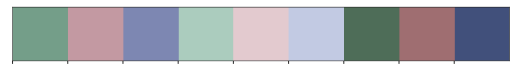

In [313]:
colors = met_brewer.met_brew(name="Monet")
sns.palplot(colors)

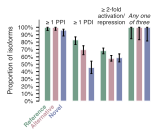

In [318]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2.1, h=1.5)
cats = ['reference', 'alternative', 'novel']
positives = []
tested = []
for cat in cats:
    positives.append(iso_sub.loc[iso_sub['valid_ppi_test'] &
                        (iso_sub['category'] == cat),
                        'at_least_one_ppi'].sum())
    tested.append(iso_sub.loc[iso_sub['valid_ppi_test'] &
                        (iso_sub['category'] == cat),
                        'at_least_one_ppi'].notnull().sum())
for cat in cats:
    positives.append(iso_sub.loc[
                        (iso_sub['category'] == cat),
                        'at_least_one_pdi'].sum())
    tested.append(iso_sub.loc[
                        (iso_sub['category'] == cat),
                        'at_least_one_pdi'].notnull().sum())
for cat in cats:
    positives.append(iso_sub.loc[
                        (iso_sub['category'] == cat),
                        'at_least_two_fold_activation'].sum())
    tested.append(iso_sub.loc[
                        (iso_sub['category'] == cat),
                        'at_least_two_fold_activation'].notnull().sum())
for cat in cats:
    tested_iso = (iso_sub['valid_ppi_test'] & 
                    iso_sub['at_least_two_fold_activation'].notnull() &
                    iso_sub['at_least_one_pdi'].notnull() &
                    (iso_sub['category'] == cat))
    positives.append((iso_sub.loc[tested_iso, 'at_least_one_ppi'] |
                 iso_sub.loc[tested_iso, 'at_least_two_fold_activation'] |
                 iso_sub.loc[tested_iso, 'at_least_one_pdi']).sum())
    tested.append(tested_iso.sum())
    
vals = [p / n for p, n in zip(positives, tested)]
#errs = [np.sqrt(((p / n) * (1 - (p / n)) / n)) for p, n in zip(positives, tested)]

pos = np.array(positives)
neg = np.array(tested) - pos
fracs = np.array(vals)
intv = stats.beta.interval(0.6827, pos + 1, neg + 1)
errs = [fracs - intv[0], intv[1] - fracs]
errs[0][pos == 0] = 0.
errs[1][neg == 0] = 0.

offset = 0.5
x_pos = ([i for i in range(3)] + 
       [i + offset for i in range(3, 6)] + 
       [i + offset * 2 for i in range(6, 9)] +
       [i + offset * 3 for i in range(9, 12)])


ax.bar(x=x_pos, height=vals, color=[colors[0], colors[1], colors[2]] * 3)
ax.errorbar(x=x_pos, y=vals, yerr=errs,
            color='black',
            fmt='none',
            linewidth=1,
            capsize=1)
ax.set_ylim(0, 1.1)
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 21), minor=True)
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])
for loc in ['top', 'bottom', 'right']:
    ax.spines[loc].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_xticks([0, 1, 2])

ax.set_xticklabels(['Reference', 
                    'Alternative',
                    'Novel'], rotation=45, ha='right', va='top', fontweight='bold')
[t.set_color(colors[i]) for i, t in enumerate(ax.xaxis.get_ticklabels())]

ax.set_ylabel('Proportion of isoforms')
ax.text(y=1.025, x=x_pos[1], s='≥ 1 PPI', 
        fontsize=6,
        va='bottom', ha='center')
ax.text(y=1.025, x=x_pos[4], s='≥ 1 PDI',
        fontsize=6,
        va='bottom', ha='center')
ax.text(y=1.025, x=x_pos[7], s='≥ 2-fold\nactivation/\nrepression',
        fontsize=6, 
        va='bottom', ha='center')
ax.text(y=1.025, x=x_pos[10], s='Any one\nof three', 
        fontsize=6, fontstyle='italic',
        va='bottom', ha='center')
fig.savefig('../../figures/fig2/at-least-some-assay-result_ref-vs-alt-vs-novel_bar.pdf',
            bbox_inches='tight')

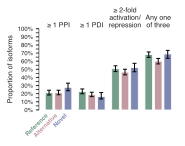

In [263]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2.5, h=1.5)
cats = ['reference', 'alternative', 'novel']
positives = []
tested = []
for cat in cats:
    positives.append(iso_sub.loc[iso_sub['valid_ppi_test'] &
                        (iso_sub['category'] == cat),
                        'at_least_one_ppi'].sum())

for cat in cats:
    positives.append(iso_sub.loc[
                        (iso_sub['category'] == cat),
                        'at_least_one_pdi'].sum())

for cat in cats:
    positives.append(iso_sub.loc[
                        (iso_sub['category'] == cat),
                        'at_least_two_fold_activation'].sum())

for cat in cats:
    positives.append((iso_sub.loc[(iso_sub['category'] == cat), 'at_least_one_ppi'].fillna(False) |
                      iso_sub.loc[(iso_sub['category'] == cat), 'at_least_two_fold_activation'].fillna(False) |
                      iso_sub.loc[(iso_sub['category'] == cat), 'at_least_one_pdi'].fillna(False)).sum())    

tested = [(iso_sub['category'] == cat).sum() for cat in cats] * 4
vals = [p / n for p, n in zip(positives, tested)]

pos = np.array(positives)
neg = np.array(tested) - pos
fracs = np.array(vals)
intv = stats.beta.interval(0.6827, pos + 1, neg + 1)
errs = [fracs - intv[0], intv[1] - fracs]
errs[0][pos == 0] = 0.
errs[1][neg == 0] = 0.

offset = 0.5
x_pos = ([i for i in range(3)] + 
       [i + offset for i in range(3, 6)] + 
       [i + offset * 2 for i in range(6, 9)] +
       [i + offset * 3 for i in range(9, 12)])
ax.bar(x=x_pos, height=vals, color=[colors[0], colors[1], colors[2]] * 3)
ax.errorbar(x=x_pos, y=vals, yerr=errs,
            color='black',
            fmt='none',
            capsize=2,
            linewidth=1)
ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 21), minor=True)
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])
for loc in ['top', 'bottom', 'right']:
    ax.spines[loc].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_xticks([0, 1, 2])

ax.set_xticklabels(['Reference', 
                    'Alternative',
                    'Novel'], rotation=45, ha='right', va='top', fontweight='bold')
[t.set_color(colors[i]) for i, t in enumerate(ax.xaxis.get_ticklabels())]

ax.set_ylabel('Proportion of isoforms')
ax.text(y=1, x=x_pos[1], s='≥ 1 PPI', 
        fontsize=7,
        va='bottom', ha='center')
ax.text(y=1, x=x_pos[4], s='≥ 1 PDI',
        fontsize=7,
        va='bottom', ha='center')
ax.text(y=1, x=x_pos[7], s='≥ 2-fold\nactivation/\nrepression',
        fontsize=7, 
        va='bottom', ha='center')
ax.text(y=1, x=x_pos[10], s='Any one\nof three', 
        fontsize=7,
        va='bottom', ha='center')
fig.savefig('../../figures/fig2/at-least-some-assay-result_ref-vs-alt-vs-novel_absolute_bar.pdf',
            bbox_inches='tight')

## 6. network ball

In [273]:
# table of edges
#    - clone to (edge + clone_id) + to duplicate
# table of nodes
#    - clone to gene
#    - dna vs isoform vs 

ppi = load_isoform_and_paralog_y2h_data()
ppi = ppi.loc[(ppi['category'] == 'tf_isoform_ppis') &
              (ppi['Y2H_result'] == True),
              ['ad_clone_acc', 'ad_gene_symbol', 'db_gene_symbol']]
ppi = ppi.rename(columns={'ad_clone_acc': 'isoform',
                          'db_gene_symbol': 'partner'})
ppi['partner'] = ppi['partner'] + '-' + ppi['ad_gene_symbol']
pdi = pd.read_csv('../../data/internal/a2_juan_pdi_w_unique_isoacc.tsv', sep='\t')
clones = load_valid_isoform_clones()
pdi = pdi.loc[pdi['unique_acc'].isin(clones['clone_acc']), :]
pdi['partner'] = pdi['bait'] + '-' + pdi['tf']
pdi['isoform'] = pdi['unique_acc']
edges = pd.concat([ppi.loc[:, ['isoform', 'partner']],
                   pdi.loc[:, ['isoform', 'partner']]])
edges.to_csv('../../output/edges.tsv', sep='\t', index=False)

clones = clones.rename(columns={'clone_acc': 'node_id'})
clones['type'] = 'isoform'
dna = pd.DataFrame(data=pdi['partner'].unique(), columns=['node_id'])
dna['type'] = 'DNA'
proteins = pd.DataFrame(data=ppi['partner'].unique(), columns=['node_id'])
proteins['type'] = 'Protein'
nodes = pd.concat([clones, proteins, dna], sort=True)
nodes.to_csv('../../output/node_table.tsv', sep='\t', index=False)